# House price analysis with SparkXshards on Orca

Copyright 2016 The BigDL Authors.

SparkXshards in Orca allows users to process large-scale dataset using existing Python codes in a distributed and data-parallel fashion, as shown below. This notebook is an example of comprehensive data exploration using SparkXshards on Orca. 

It is adapted from [Kagge Comprehensive data exploration with Python](https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python/notebook) notebook on house price analysis.


In [ ]:
# Use seaborn for some plots
!pip install seaborn pandas numpy

In [ ]:
# import necessary libraries
import bigdl.orca.data.pandas
from bigdl.dllib.nncontext import init_nncontext
from bigdl.orca.data.transformer import *
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

## 1. Load data in parallel and get general information

Load data into data_shards, it is a SparkXshards that can be operated on in parallel, here each element of the data_shards is a panda dataframe read from a file on the cluster. Users can distribute local code of `pd.read_csv(dataFile)` using `bigdl.orca.data.pandas.read_csv(datapath)`.

In [ ]:
data_shards = bigdl.orca.data.pandas.read_csv('../house_price/train.csv', nullValue="NA")

In [4]:
# show the first couple of rows in the data_shards
data_shards.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [5]:
# see the num of partitions of data_shards
data_shards.num_partitions()


1

In [6]:
# count total number of rows in the data_shards
len(data_shards)

1460

## 2. Analysing 'SalePrice'

'SalePrice' is the reason of our quest. Users can compute the descriptive statistics summary of 'SalePrice' on the full data_shards in a distributed way. For local visualization, users can sample a portion of the data_shards acroos the cluster into a local panda dataframe, then analyze it using traditional tools like seaborn for plots.

### 2.1 Statistics summary of 'SalePrice' on full data_shards

In [7]:
data_shards.select("SalePrice").describe()

createDataFrame from shards attempted Arrow optimization failed as: 'NoneType' object has no attribute 'json',Will try without Arrow optimization


,summary,SalePrice
0,count,1460
1,mean,180921.19589041095
2,stddev,79442.50288288663
3,min,34900
4,max,755000


### 2.2 Local visualization of 'SalePrice' on sampled PDF

Users can call `data_shards.sample_to_pdf(frac)` to sample a portion of the data_shards and bring back to a panda dataframe on local for visualization. 
Just a few examples are shown in here.

In [8]:
# 0 < frac <= 1, here frac = 1.0 is chosen to collect and show full data.
pdf = data_shards.sample_to_pdf(frac = 1.0)

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

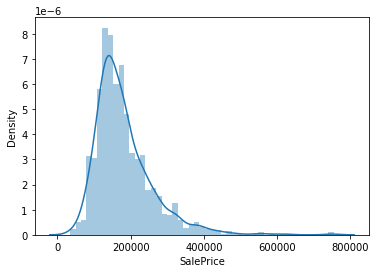

In [9]:
# histogram of 'SalePrice'
sns.distplot(pdf['SalePrice'])

Plot scatter plots to show relationship with numerical variables.

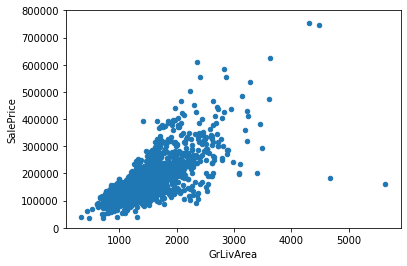

In [10]:
#scatter plot grlivarea/saleprice
var = 'GrLivArea'
data = pd.concat([pdf['SalePrice'], pdf[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

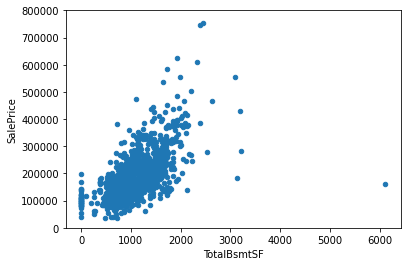

In [11]:
#scatter plot totalbsmtsf/saleprice
var = 'TotalBsmtSF'
data = pd.concat([pdf['SalePrice'], pdf[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

Show relationship with categorical features¶

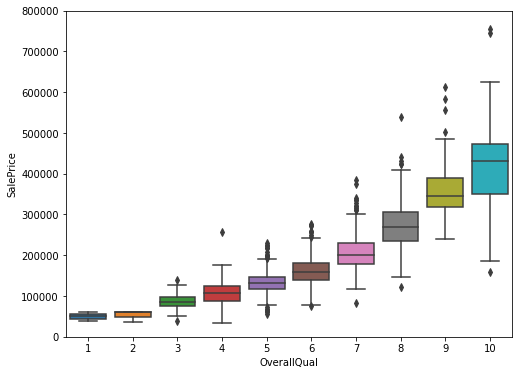

In [12]:
#box plot overallqual/saleprice
var = 'OverallQual'
data = pd.concat([pdf['SalePrice'], pdf[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

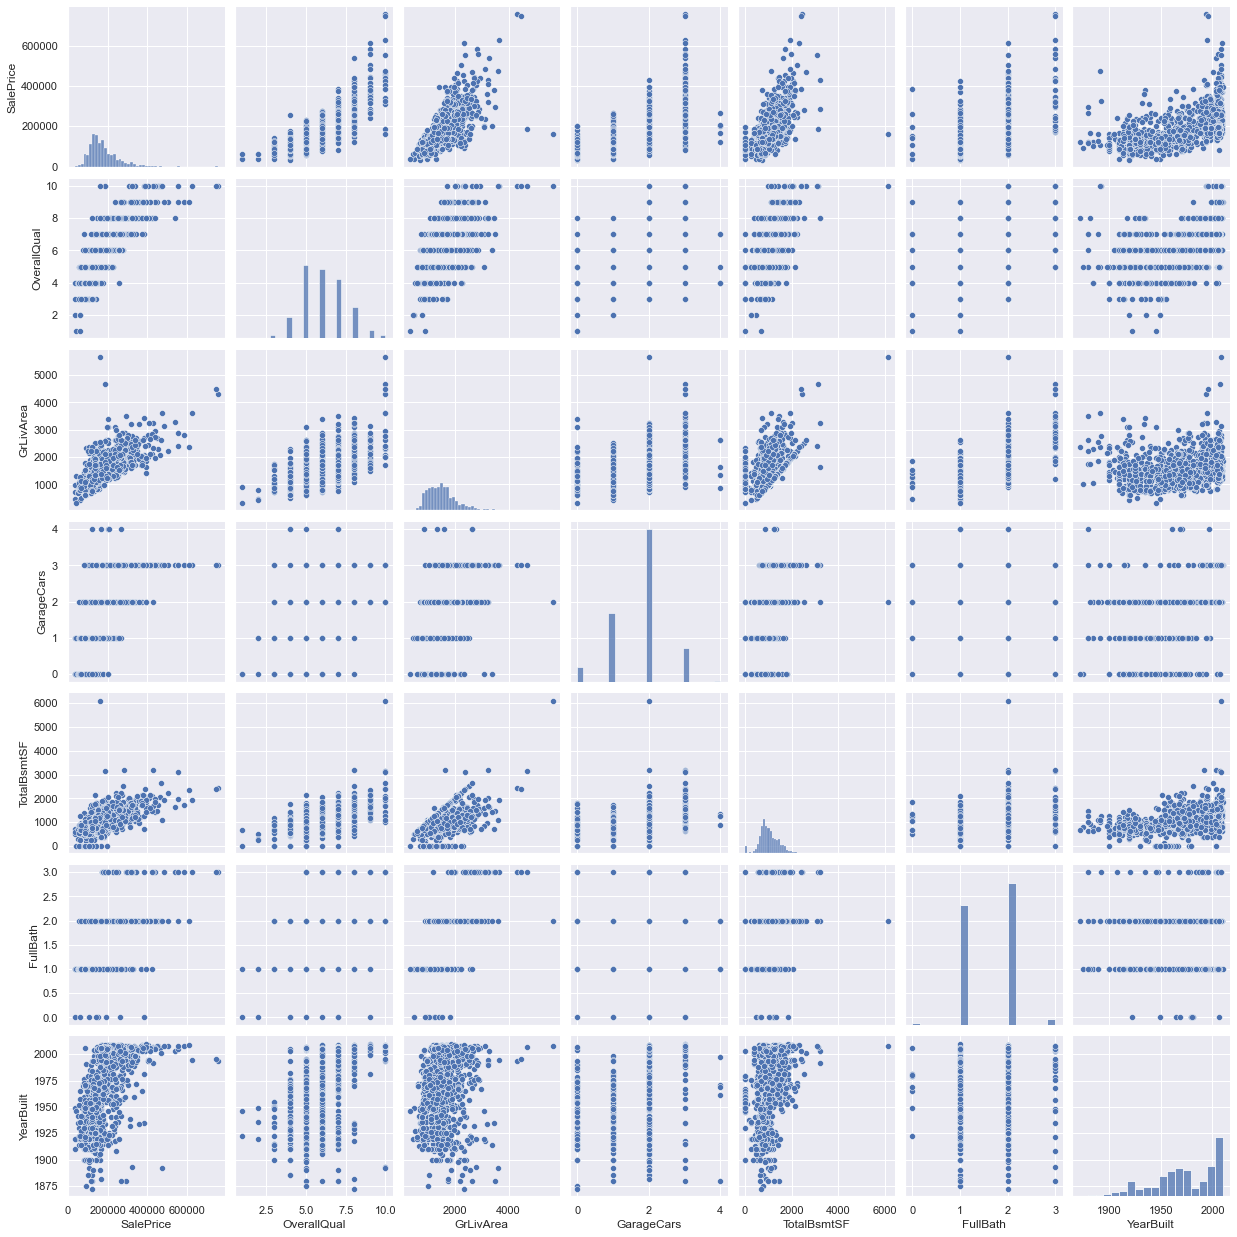

In [13]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(pdf[cols], size = 2.5)
plt.show();

## 3. Deal with missing data in parallel

It is important to understand the missing data. User can get the stats of full data shards on the cluster.

In [14]:
null_cnt_pdf = data_shards.get_null_sum().sort_values(by="total", ascending=False)
null_cnt_pdf["percent"] = null_cnt_pdf["total"] / len(data_shards)
null_cnt_pdf.head(20)

,col,total,percent
72,PoolQC,1453,0.995205
74,MiscFeature,1406,0.963014
6,Alley,1369,0.937671
73,Fence,1179,0.807534
57,FireplaceQu,690,0.472603
3,LotFrontage,259,0.177397
59,GarageYrBlt,81,0.055479
64,GarageCond,81,0.055479
58,GarageType,81,0.055479
60,GarageFinish,81,0.055479


Drop records which have missing data and evaluate results, `max_value` is count of missing data in a column, should be 0 is all missing data is dropped.

In [15]:
#dealing with missing data
new_ds = data_shards.drop_missing_value()

# verify missing value has been removed
new_cnt_pdf = new_ds.get_null_sum()
max_value = new_cnt_pdf['total'].max()
max_value

<string>:550: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


0

## 4. Data transformation and feature engineering in parallel

Apply transformation on the data for feature engineering. Users can define transformation function and call `transform_shard` to do feature engineering. Here it showcases how to do a log transformation of 'SalePrice' and extact binary feature column of 'HasBsmt' using 'TotalBsmtSF' column.

In [16]:
# log transformation of the data_shards
def generate_new_sale_price(df):
    df['SalePrice'] = np.log(df['SalePrice'])
    return df
new_ds2 = new_ds.transform_shard(generate_new_sale_price)
new_ds2.select('SalePrice').head(20)

,SalePrice
0,12.247694
1,12.109011
2,12.317167
3,11.849398
4,12.429216
5,11.870600
6,12.634603
7,12.206073
8,11.774520
9,11.678440


In [17]:
# create column for new variable (one is enough because it's a binary categorical feature)
def generate_HasBsmt(df):
    df['HasBsmt'] = 0
    df.loc[df['TotalBsmtSF'] > 0, 'HasBsmt'] = 1
    return df
new_ds3 = new_ds2.transform_shard(generate_HasBsmt)
new_ds3.select(['TotalBsmtSF', 'HasBsmt']).head(20)


,TotalBsmtSF,HasBsmt
0,856,1
1,1262,1
2,920,1
3,756,1
4,1145,1
5,796,1
6,1686,1
7,1107,1
8,952,1
9,991,1
